In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import ndimage

from tardis.simulation import Simulation
from tardis.io.config_reader import Configuration
from tardis.io.atom_data import AtomData
from tardis.plasma.base import BasePlasma
from tardis.plasma.properties.base import DataFrameInput, ProcessingPlasmaProperty
from tardis.plasma.properties.property_collections import (
    basic_inputs,
    basic_properties,
    lte_excitation_properties,
    lte_ionization_properties,
    macro_atom_properties,
    dilute_lte_excitation_properties,
    nebular_ionization_properties,
    non_nlte_properties,
    nlte_properties,
    helium_nlte_properties,
    helium_numerical_nlte_properties,
    helium_lte_properties,
    detailed_j_blues_properties,
    detailed_j_blues_inputs,
    continuum_interaction_properties,
    continuum_interaction_inputs,
    adiabatic_cooling_properties,
    two_photon_properties,
)

from astropy import units as u, constants as const


Iterations:          0/? [00:00<?, ?it/s]

Packets:             0/? [00:00<?, ?it/s]

In [2]:

from stardis.plasma import AlphaLine, HMinusDensity, TracingNus
from star_test import calc_tau_h_minus, calc_tau_nus, calc_weights

In [3]:
sun_spec = pd.read_csv('data/solar_data/NewGuey2003.txt', skiprows=20, delim_whitespace=True, names=['wave', 'flux'])
sun_spec['wave'] *= 10
sun_spec['flux'] = u.Quantity(sun_spec['flux'].to_numpy(), "W/(m2 nm)").to("erg/(s cm2 AA)").value

(2000.0, 9000.0)

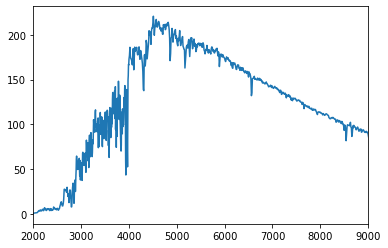

In [4]:
plt.plot(sun_spec.wave, sun_spec.flux)
plt.xlim(2000, 9000)

## Model & Atomic Data

In [5]:
def read_marcs(fname, atom_data):
    marcs_model1 = pd.read_csv(fname,skiprows=24, nrows=56, 
                               delim_whitespace=True, index_col='k')
    marcs_model2 = pd.read_csv(fname,skiprows=81, nrows=56, 
                               delim_whitespace=True, index_col='k')
    del marcs_model2['lgTauR']
    marcs_model = marcs_model1.join(marcs_model2)
    marcs_model.columns = [item.lower() for item in marcs_model.columns]
    marcs_model['lgtaur'] = 10**marcs_model['lgtaur']
    marcs_model['lgtau5'] = 10**marcs_model['lgtau5']
    
    marcs_model = marcs_model.rename(columns={'lgtaur':'tau_ref', 'lgtau5':'tau_500'})
    with open(fname) as fh:
        marcs_lines = fh.readlines()
    marcs_abundance_scale_str = ' '.join([item.strip() for item in marcs_lines[12:22]])
    marcs_abundances = pd.DataFrame(data=map(np.float64, marcs_abundance_scale_str.split()), columns=['abundance_scale'])
    marcs_abundances.replace({-99:np.nan}, inplace=True)
    marcs_abundances = marcs_abundances.set_index(np.arange(1, len(marcs_abundances)+1))
    marcs_abundances.index.name = 'atomic_number'
    marcs_abundances['mass_density'] = ((10**marcs_abundances['abundance_scale']) * 
                                        atom_data.atom_data.mass)
    marcs_abundances['mass_abundance'] = marcs_abundances['mass_density'] / marcs_abundances['mass_density'].sum()
    return marcs_model[::-1], marcs_abundances

# Converting model from finite difference to finite volume (cell boundaries to cells)
# Shape changes here because of averaging adjacent rows
def convert_marcs_finite_volume(marcs_model):
    marcs_model_fv = pd.DataFrame(data=0.5 * (marcs_model.iloc[:-1].values + marcs_model.iloc[1:].values), 
                                columns=marcs_model.columns)
    marcs_model_fv['r_inner'] = marcs_model['depth'].iloc[:-1].values
    marcs_model_fv['r_outer'] = marcs_model['depth'].iloc[1:].values
    marcs_model_fv['cell_length'] = -(marcs_model_fv['r_outer'].values - marcs_model_fv['r_inner'].values)
    return marcs_model_fv

In [6]:
adata = AtomData.from_hdf('kurucz_cd23_chianti_H_He.h5')
#adata.prepare_atom_data(marcs_abundances_all.index.tolist())
marcs_model, marcs_abundances_uniform = read_marcs('data/marcs/sun.mod', adata)

In [7]:
marcs_model_fv = convert_marcs_finite_volume(marcs_model)

In [8]:
marcs_abundances_all = pd.DataFrame(columns=marcs_model_fv.index.values, 
                    index=marcs_abundances_uniform.index)
for i in range(len(marcs_abundances_all.columns)):
    marcs_abundances_all[i] = marcs_abundances_uniform['mass_abundance']
#marcs_abundances_all = marcs_abundances_all.loc[30:1][::-1]

# pure hydrogen
marcs_abundances_all = marcs_abundances_all.iloc[[0]]
marcs_abundances_all.iloc[:] = 1.0

In [9]:
adata = AtomData.from_hdf('kurucz_cd23_chianti_H_He.h5')
adata.prepare_atom_data(marcs_abundances_all.index.tolist())

## Plasma

In [10]:
# Code that hasn't seen light of the day yet, might be useful in future

class InputNumberDensity(DataFrameInput):
    """
    Attributes
    ----------
    number_density : Pandas DataFrame, dtype float
                     Indexed by atomic number, columns corresponding to zones
    """

    outputs = ("number_density",)
    latex_name = ("N_{i}",)
    
class SelectedAtoms(ProcessingPlasmaProperty):
    """
    Attributes
    ----------
    selected_atoms : Pandas Int64Index, dtype int
                     Atomic numbers of elements required for particular simulation
    """

    outputs = ("selected_atoms",)

    def calculate(self, number_density):
        return number_density.index

def assemble_plasma(marcs_df):
    pass

In [11]:
import tardis.plasma

#basic_properties.remove(tardis.plasma.properties.general.NumberDensity)
plasma_modules = []
plasma_modules += basic_inputs
plasma_modules += basic_properties
plasma_modules += lte_ionization_properties
plasma_modules += lte_excitation_properties
plasma_modules += non_nlte_properties

plasma_modules.append(tardis.plasma.properties.partition_function.LevelBoltzmannFactorNoNLTE)
plasma_modules.remove(tardis.plasma.properties.radiative_properties.TauSobolev)
plasma_modules.remove(tardis.plasma.properties.plasma_input.TimeExplosion)
plasma_modules.remove(tardis.plasma.properties.plasma_input.DilutionFactor)
plasma_modules.remove(tardis.plasma.properties.plasma_input.HeliumTreatment)
plasma_modules.remove(tardis.plasma.properties.plasma_input.ContinuumInteractionSpecies)
plasma_modules+= helium_lte_properties
plasma_modules.append(AlphaLine)
plasma_modules.append(HMinusDensity)
plasma_modules.append(TracingNus)
#plasma_modules.remove(tardis.plasma.properties.radiative_properties.StimulatedEmissionFactor)

#plasma_modules.remove(tardis.plasma.properties.general.SelectedAtoms)
#plasma_modules.remove(tardis.plasma.properties.plasma_input.Density)


In [12]:
tracing_wavelength = np.arange(2000, 10000, 0.1) * u.Angstrom
tracing_nus = tracing_wavelength.to(u.Hz, u.spectral())

splasma = BasePlasma(
        plasma_properties=plasma_modules,
        t_rad=marcs_model_fv.t.values, abundance=marcs_abundances_all,
        atomic_data=adata, 
        density=marcs_model_fv.density.values,
        link_t_rad_t_electron=1.0,
        tracing_nus=tracing_nus 
        )

## RT Calculation

In [13]:
tau_h_minus = calc_tau_h_minus(
    h_neutral_density=splasma.ion_number_density.loc[(1, 0)].values,
    temperature=marcs_model_fv.t.values * u.K,
    electron_density=splasma.electron_densities.values,
    wbr_fpath="data/wishart_broad_reinhardt_cross_section.dat",
    tracing_wavelength=tracing_wavelength.value,
    cell_length=marcs_model_fv.cell_length.values,
)

In [14]:
# alpha value (=n x sigma) of each line for all 55 cells
# shape of splasma.alpha_line: (74, 55), splasma has 74 lines (aka atomic transitions)
alpha_line = splasma.alpha_line.reset_index(drop=True).values[::-1]
delta_tau_lines = alpha_line * marcs_model_fv.cell_length.values # shape: (74, 55)

In [15]:
tau_h_minus.shape, delta_tau_lines.shape

((55, 80000), (74, 55))

In [16]:
# transition doesn't happen at a specific nu due to several factors (changing temperatires, doppler shifts, relativity, etc.)
# so we take a window 2e11 Hz wide - if nu falls within that, we consider it

lines_nu = splasma.lines.nu.values[::-1] # reverse to bring them to ascending order

# search_sorted finds the index before which a (tracing_nu +- 1e11) can be inserted 
# in lines_nu array to maintain its sort order
line_id_starts = lines_nu.searchsorted(tracing_nus.value-1e11)
line_id_ends = lines_nu.searchsorted(tracing_nus.value+1e11)

### Source function

In [17]:
# bb shape: (56, 800000), calculated at each cell boundary
bb_prefactor = (2 * const.h.cgs * tracing_nus ** 3) / const.c.cgs ** 2
bb = bb_prefactor / (
    np.exp(
        (
            (const.h.cgs * tracing_nus)
            / (const.k_B.cgs * marcs_model.t.values[None].T * u.K)
        ).value
    )
    - 1
)

In [18]:
tw_cm = tracing_wavelength.to("cm")

In [19]:
bbw_prefactor = (2 * const.h.cgs * const.c.cgs ** 2) / tw_cm ** 5
bbw = bbw_prefactor / (
    np.exp(
        (
            (const.h.cgs * const.c.cgs)
            / (const.k_B.cgs * tw_cm * marcs_model.t.values[None].T * u.K)
        ).value
    )
    - 1
)

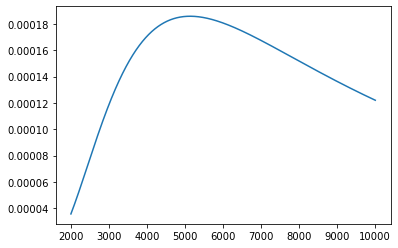

In [20]:
plt.plot(tracing_wavelength,bb[0])

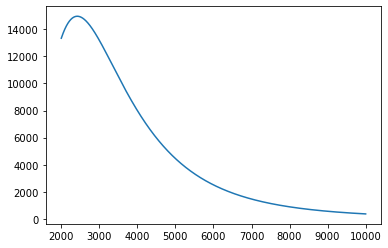

In [21]:
plt.plot(tracing_wavelength,bb[0]*tracing_nus/tracing_wavelength**2)

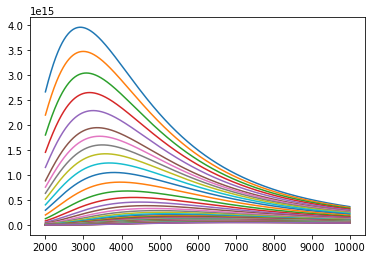

In [22]:
for i in range(55):
    plt.plot(tracing_wavelength,bbw[i])

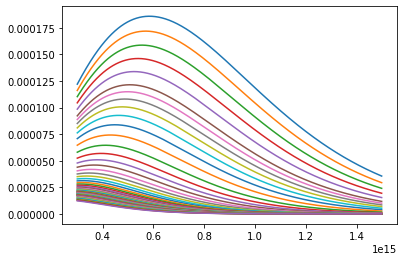

In [23]:
for i in range(55):
    plt.plot(tracing_nus,bb[i])

In [24]:
marcs_model.t.values

array([9934.3, 9678.4, 9424.6, 9168.5, 8903.8, 8620.2, 8462.6, 8290.4,
       8097.7, 7876.9, 7618.2, 7314.8, 6983.3, 6694.8, 6451.9, 6235.2,
       6044.3, 5875.7, 5727.4, 5597.1, 5483.1, 5382.5, 5294.4, 5216.8,
       5148.5, 5088.6, 5034.4, 4988.1, 4944.1, 4905.9, 4870.5, 4838.3,
       4808.6, 4780.9, 4754.7, 4729.9, 4706. , 4682.9, 4660.2, 4637.8,
       4615.6, 4593.5, 4571.5, 4549.5, 4527.4, 4504.9, 4461. , 4416.3,
       4371.3, 4326.1, 4280.8, 4235.5, 4190.4, 4145.9, 4102.6, 4066.8])

In [25]:
bb

<Quantity [[3.55959357e-05, 3.56034942e-05, 3.56110532e-05, ...,
            1.22027529e-04, 1.22026178e-04, 1.22024827e-04],
           [2.93895734e-05, 2.93960942e-05, 2.94026156e-05, ...,
            1.16103206e-04, 1.16101953e-04, 1.16100700e-04],
           [2.40555887e-05, 2.40611660e-05, 2.40667438e-05, ...,
            1.10282259e-04, 1.10281102e-04, 1.10279944e-04],
           ...,
           [1.44617736e-09, 1.44721544e-09, 1.44825414e-09, ...,
            1.27545087e-05, 1.27545829e-05, 1.27546571e-05],
           [1.20416678e-09, 1.20504218e-09, 1.20591811e-09, ...,
            1.22816059e-05, 1.22816815e-05, 1.22817571e-05],
           [1.03192698e-09, 1.03268513e-09, 1.03344375e-09, ...,
            1.18970502e-05, 1.18971268e-05, 1.18972034e-05]] erg Hz3 s3 / cm2>

In [26]:
source = bb[1:].value
delta_source = bb.diff(axis=0).value  # for cells, not boundary

### RT Equation

In [27]:
# I_nu (specific intensity) is calculated at each cell boundary, shape: (56,800000)
I_nu = np.ones((delta_tau_lines.shape[1] + 1, len(tracing_nus))) * -99
I_nu[0] = bb[0]  # the innermost boundary is photosphere
num_of_shells = len(I_nu) - 1

for i in range(len(tracing_nus)):  # iterating over nus (columns)
    nu, line_id_start, line_id_end = (
        tracing_nus[i],
        line_id_starts[i],
        line_id_ends[i],
    )

    if line_id_start != line_id_end:
        delta_tau = delta_tau_lines[line_id_start:line_id_end]
        delta_nu = nu.value - lines_nu[line_id_start:line_id_end]
        tau_nus = calc_tau_nus(delta_tau, delta_nu)

    else:
        tau_nus = np.zeros(I_nu.shape[0] - 1)

    for j in range(num_of_shells):  # iterating over cells/shells (rows)
        cur_tau_h_minus = tau_h_minus[j,i]
        delta_tau_nu = tau_nus[j] + cur_tau_h_minus 
        w0, w1 = calc_weights(delta_tau_nu)

        if tau_nus[j] == 0:
            second_term = 0
        else:
            second_term = w1 * delta_source[j, i] / delta_tau_nu

        I_nu[j + 1, i] = (1 - w0) * I_nu[j, i] + w0 * source[j, i] + second_term # van Noort 2001 eq 14



### Plotting

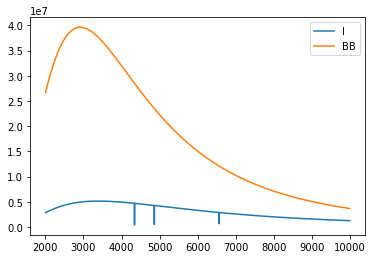

In [28]:
I_lambda = (I_nu[55])*tracing_nus/tracing_wavelength

cur_bb = bb[0]*tracing_nus/tracing_wavelength #TODO: check why 0, shouldn't it be 55 like I_nu?

plt.plot(tracing_wavelength, I_lambda, label="I")
plt.plot(tracing_wavelength, cur_bb, label="BB")
# plt.xlim(4330,4350) # to see 1st feature
# plt.xlim(6500, 6600) # to see last feature
#plt.xlim(2000,10000) 
plt.legend()

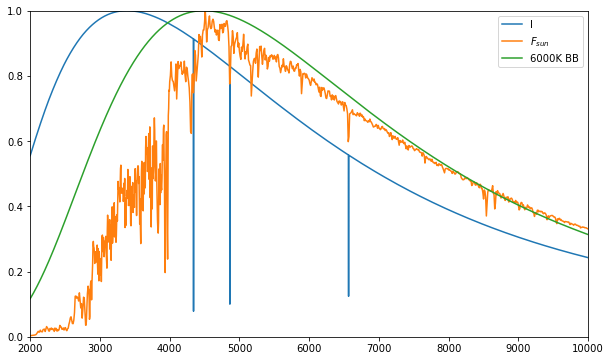

In [30]:
plt.figure(figsize=(10,6))
plt.plot(tracing_wavelength, I_lambda/I_lambda.max(), label="I")
plt.plot(sun_spec.wave, sun_spec.flux/sun_spec.flux.max(), label="$F_{sun}$")
plt.plot(tracing_wavelength,bbw[14]/bbw[14].max(), label="6000K BB")
plt.ylim(0, 1)

plt.xlim((2000,10000))
plt.legend()

In [ ]:
(const.b_wien/(9000 * u.K)).to(u.angstrom)

In [ ]:
I_nu.shape

In [ ]:
weights = np.genfromtxt("weights.txt")

In [ ]:
plt.plot(np.arange(55), np.array_split(weights, 8)[3])